In [0]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
import matplotlib.pyplot as plt
from fastai.metrics import psnr
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import random
from skimage import io
from PIL import Image

## 0. Downloading the data and taking a look at it

In [0]:
path = untar_data(URLs.IMAGENETTE_160)

In [0]:
img = plt.imread(path/'train/n01440764/n01440764_13464.JPEG')

In [4]:
img.shape

(160, 178, 3)

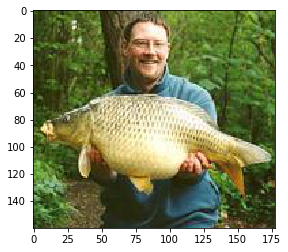

In [5]:
plt.imshow(img)

## 1. Creating the Datasets and Dataloaders

In [0]:
files = os.listdir(path/'train/n01440764')

In [0]:
idx =  random.sample(range(0, len(files)), int(len(files)*0.2))

files_series = pd.Series(files)

files_val = list(files_series.loc[idx])
files_train = list(files_series.drop(idx))

In [0]:
class CustomDataset(Dataset):
    def __init__(self,root, files, window_size=30, tfms=None):
        self.root = root
        self.files = files
        self.window_size=window_size
        self.tfms = tfms
        
    def __len__(self): return len(self.files)
        
    def show(self,idx):
        sample = self.__getitem__(idx)
        #fig=plt.figure(figsize=(5, 5))
        f, ax = plt.subplots(1,2)
        #import pdb;pdb.set_trace()
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        x = (sample[0].numpy().transpose((1,2,0))*stds + means)*255
        y = (sample[1].numpy().transpose((1,2,0))*stds + means)*255
        ax[0].imshow(x.astype(np.uint8))
        ax[1].imshow(y.astype(np.uint8))    
        
            
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #import pdb;pdb.set_trace()
        img = io.imread(self.root + '/' + self.files[idx])
        #import pdb;pdb.set_trace()
        #img = img.transpose((2,0,1))
        #img = torch.from_numpy(img)
        
        if self.tfms: 
            #import pdb;pdb.set_trace()
            img = self.tfms(Image.fromarray(img))
            #import pdb;pdb.set_trace()

        
        row_init = np.random.randint(0,img.shape[1]-self.window_size)
        col_init = np.random.randint(0,img.shape[2]-self.window_size)
        #import pdb;pdb.set_trace()
        target = img[:,row_init:row_init+self.window_size,col_init:col_init+self.window_size]
        img_window = img.clone()
        img_window[0,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.485)/0.229
        img_window[1,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.456)/0.224
        img_window[2,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.406)/0.225

        sample = (img_window,target)
        
        return sample

In [0]:
tfms = transforms.Compose([
        transforms.RandomResizedCrop(160,scale=(0.8,1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [0]:
train_ds = CustomDataset(str(path)+'/train/n01440764',files_train,tfms=tfms,window_size=29)
valid_ds = CustomDataset(str(path)+'/train/n01440764',files_val,tfms=tfms,window_size=29)

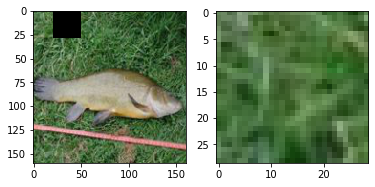

In [34]:
train_ds.show(0)

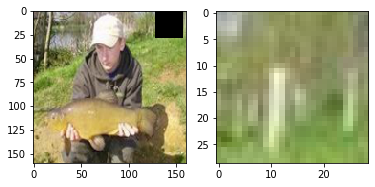

In [35]:
valid_ds.show(0)

In [0]:
train_dl = DataLoader(train_ds, batch_size=16,shuffle=True,num_workers=2)
valid_dl = DataLoader(train_ds, batch_size=16,shuffle=True,num_workers=2)

In [0]:
inputs, classes = next(iter(train_dl))

In [38]:
inputs.shape, classes.shape

(torch.Size([16, 3, 160, 160]), torch.Size([16, 3, 29, 29]))

## 2. Creating the model

In [0]:
mdl = models.resnet34(pretrained=True)

In [0]:
encoder = nn.Sequential(*list(mdl.children())[:-2])

In [18]:
encodings = encoder(inputs)
encodings.shape

torch.Size([16, 512, 5, 5])

In [0]:
def noop(x): return x

In [0]:
act_fn = nn.ReLU(inplace=True)

In [0]:
def conv(ni, nf, ks=3, stride=1, bias=False, padding=1):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias)

In [0]:
def conv_layer(ni, nf, ks=3, stride=1, padding=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride,padding=padding), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

In [0]:
class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1,padding=1):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 1)]
        layers += [
            conv_layer(nh, nf, 3, stride=stride, zero_bn=True, act=False, padding=padding)
        ] if expansion==1 else [
            conv_layer(nh, nh, 3, stride=stride, padding=padding),
            conv_layer(nh, nf, 1, zero_bn=True, act=False, padding=padding)
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False, padding=padding)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [0]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.conv1 = ResBlock(1,512,256,padding=2)
        self.conv2 = ResBlock(1,256,128,padding=2)
        self.conv3 = ResBlock(1,128,64,padding=2)
        self.conv4 = ResBlock(1,64,32,padding=2)
        self.conv5 = ResBlock(1,32,16,padding=2)
        self.conv6 = ResBlock(1,16,8,padding=2)
        self.conv7 = ResBlock(1,8,3,padding=1)
        self.conv8 = ResBlock(1,3,3,padding=0)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        
        return x

In [0]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.conv1 = ResBlock(1,512,64,padding=5)
        self.conv4 = ResBlock(1,64,16,padding=5)
        self.conv7 = ResBlock(1,16,3,padding=2)
        self.conv8 = ResBlock(1,3,3,padding=0)
        self.conv9 = ResBlock(1,3,3,padding=0)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv4(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        
        return x

In [0]:
fillNet = nn.Sequential(encoder,Decoder())

In [32]:
bla = fillNet(inputs)
bla.shape

torch.Size([16, 3, 29, 29])

## 3. Creating the Databunch and Learner

In [0]:
data = DataBunch(train_dl,valid_dl)

In [0]:
learn = Learner(data, fillNet, loss_func=nn.MSELoss(), metrics = [psnr], callback_fns=ShowGraph)

In [0]:
#creating the layer groups so that I can use discriminative learning rates
#learn.split([learn.model.layers[:4], learn.model.layers[4:8], learn.model.layers[8:]])

In [0]:
#first I'll train only the decoder
for param in learn.model[0].parameters():
    param.requires_grad = False

for param in learn.model[1].parameters():
    param.requires_grad = True

In [62]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.55E+01
Min loss divided by 10: 2.40E-01


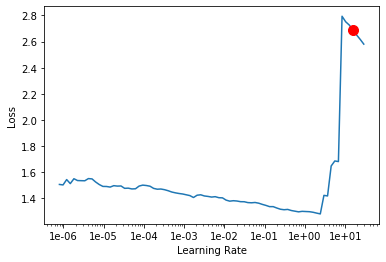

In [63]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,psnr,time
0,1.173463,1.194332,-0.702990,00:05
1,1.165927,1.170551,-0.612924,00:05
2,1.166855,1.172789,-0.603777,00:05
3,1.184640,1.224987,-0.809355,00:05
4,1.184453,1.154926,-0.585435,00:05
5,1.174524,1.150731,-0.520842,00:05
6,1.205882,1.273929,-0.988193,00:05
7,1.153377,1.195379,-0.709304,00:05
8,1.145248,1.184801,-0.663179,00:05
9,1.183127,1.249481,-0.877262,00:05


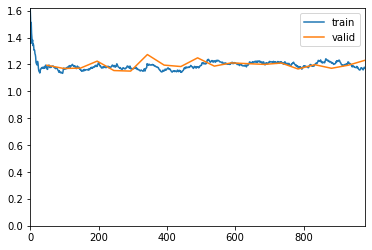

Better model found at epoch 0 with valid_loss value: 1.194332242012024.
Better model found at epoch 1 with valid_loss value: 1.170551061630249.
Better model found at epoch 4 with valid_loss value: 1.1549255847930908.
Better model found at epoch 5 with valid_loss value: 1.1507306098937988.


In [64]:
learn.fit_one_cycle(20, max_lr=1e-1,
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-1')],)

In [0]:
def show_results(learn,figsize=(5,5)):
    inputs,classes = next(iter(learn.data.valid_dl))
    preds = learn.model(inputs)
    stds = np.array([0.229, 0.224, 0.225])
    means = np.array([0.485, 0.456, 0.406])
    inp = (inputs[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    target = (classes[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    pred = (preds[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255

    mse = np.sum(((pred - target)**2))/(pred.shape[0]*pred.shape[1]*pred.shape[2])
    psnr = 10*np.log10(255/mse)

    print('MSE:',mse)
    print('PSNR:', psnr)

    #import pdb;pdb.set_trace()

    fig = plt.figure(figsize=figsize)
    ax0 = fig.add_subplot(131)
    ax0.imshow(inp.astype(np.uint8))
    ax0.title.set_text('Input')
    ax1 = fig.add_subplot(132)
    ax1.imshow(target.astype(np.uint8))
    ax1.title.set_text('Target')
    ax2 = fig.add_subplot(133)
    ax2.imshow(pred.astype(np.uint8))
    ax2.title.set_text('Prediction')

In [0]:
learn.load('stage-1')

MSE: 1245.747856401495
PSNR: -6.888899681052637


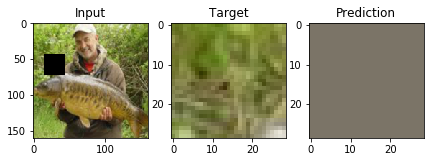

In [68]:
show_results(learn,figsize=(7,7))

In [0]:
#now I'll train all the parameters
for param in learn.model[0].parameters():
    param.requires_grad = True

for param in learn.model[1].parameters():
    param.requires_grad = True

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.00E-04


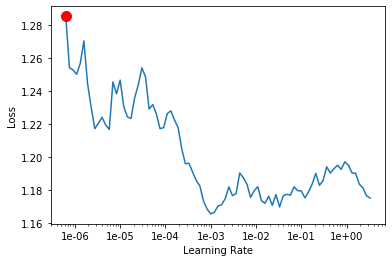

In [70]:
#learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,psnr,time
0,1.202546,1.186279,-0.669654,00:06
1,1.176948,1.193538,-0.695382,00:06
2,1.165215,1.202751,-0.724789,00:06
3,1.176963,1.195630,-0.691904,00:06
4,1.194648,1.195986,-0.684653,00:06
5,1.199931,1.163240,-0.600088,00:06
6,1.183942,1.216924,-0.755780,00:06
7,1.211712,1.126624,-0.456025,00:06
8,1.207261,1.205433,-0.761428,00:06
9,1.229478,1.225933,-0.803767,00:06


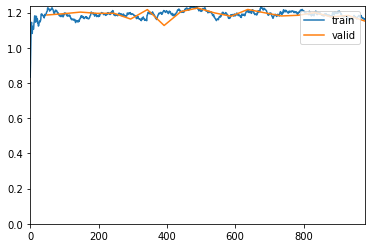

Better model found at epoch 0 with valid_loss value: 1.1862791776657104.
Better model found at epoch 5 with valid_loss value: 1.1632399559020996.
Better model found at epoch 7 with valid_loss value: 1.1266238689422607.


In [71]:
learn.fit_one_cycle(20, 3e-4,
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-2')])

In [0]:
learn.load('stage-2')

MSE: 5802.345419070852
PSNR: -13.5706339876056


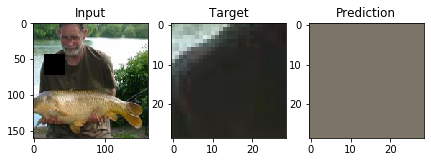

In [73]:
show_results(learn,figsize=(7,7))